In [1]:
# Volatility Analysis: NVIDIA vs S&P 500
# Using actual data from yfinance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import yfinance as yf

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Define date ranges - using actual historical data from yfinance
# Start from 2019-01-01 for main analysis period
main_start = pd.Timestamp('2019-01-01')
main_end = pd.Timestamp.now()

# Extend start date (~90 calendar days) so 30-day rolling window has enough history before main_start
extended_start = main_start - pd.Timedelta(days=90)
print(f"Downloading NVDA and S&P 500 stock prices from yfinance...")
print(f"Extended date range: {extended_start.date()} to {main_end.date()}")
print(f"Primary analysis date range: {main_start.date()} to {main_end.date()}")

nvda_data = yf.download("NVDA", start=extended_start.strftime('%Y-%m-%d'), end=main_end.strftime('%Y-%m-%d'), auto_adjust=True, progress=False)
sp500_data = yf.download("^GSPC", start=extended_start.strftime('%Y-%m-%d'), end=main_end.strftime('%Y-%m-%d'), auto_adjust=True, progress=False)

# Extract NVDA close prices
if isinstance(nvda_data.columns, pd.MultiIndex):
    if ('Close', 'NVDA') in nvda_data.columns:
        nvda_prices = nvda_data[('Close', 'NVDA')]
    else:
        nvda_prices = nvda_data.xs('Close', level=0, axis=1).iloc[:, 0]
else:
    nvda_prices = nvda_data['Close'] if 'Close' in nvda_data.columns else nvda_data.iloc[:, 0]

if isinstance(nvda_prices, pd.DataFrame):
    nvda_prices = nvda_prices.iloc[:, 0]

# Extract S&P 500 close prices
if isinstance(sp500_data.columns, pd.MultiIndex):
    if ('Close', '^GSPC') in sp500_data.columns:
        sp500_prices = sp500_data[('Close', '^GSPC')]
    else:
        sp500_prices = sp500_data.xs('Close', level=0, axis=1).iloc[:, 0]
else:
    sp500_prices = sp500_data['Close'] if 'Close' in sp500_data.columns else sp500_data.iloc[:, 0]

if isinstance(sp500_prices, pd.DataFrame):
    sp500_prices = sp500_prices.iloc[:, 0]

print(f"NVDA prices loaded: {len(nvda_prices)} observations")
print(f"Price range: ${nvda_prices.min():.2f} - ${nvda_prices.max():.2f}")
print(f"\nS&P 500 prices loaded: {len(sp500_prices)} observations")

# Define AI boom split date
split_date = pd.Timestamp('2022-10-01')
print(f"\nAI Boom Start Date: {split_date.strftime('%B %d, %Y')}")


Extended date range: 2018-10-03 to 2025-11-13
Primary analysis date range: 2019-01-01 to 2025-11-13
NVDA prices loaded: 1788 observations
Price range: $3.15 - $207.04

S&P 500 prices loaded: 1788 observations

AI Boom Start Date: October 01, 2022


## Plot 1: NVDA Stock Prices vs Market Volatility

This plot shows NVDA stock prices (green line) alongside S&P 500 market volatility (blue line) to visualize how market volatility affects NVDA stock prices over time, with a clear indicator of the post-AI boom period.

### Data Used for Plot 1


In [2]:
# Prepare data for Plot 1 and create dataframe (30-day rolling volatility)
# Calculate NVDA returns using extended price history
nvda_returns_ext = nvda_prices.pct_change()

# Calculate S&P 500 returns using extended price history
sp500_returns_ext = sp500_prices.pct_change()

# 30-day rolling historical volatility (annualized %) for NVDA
nvda_vol_30d_ext = nvda_returns_ext.rolling(window=30, min_periods=30).std() * np.sqrt(252) * 100

# 30-day rolling historical volatility (annualized %) for S&P 500
sp500_vol_30d_ext = sp500_returns_ext.rolling(window=30, min_periods=30).std() * np.sqrt(252) * 100

# Align rolling volatility to primary window and ensure no gaps
nvda_vol_30d = nvda_vol_30d_ext.loc[(nvda_vol_30d_ext.index >= main_start) & (nvda_vol_30d_ext.index <= main_end)]
sp500_vol_30d = sp500_vol_30d_ext.loc[(sp500_vol_30d_ext.index >= main_start) & (sp500_vol_30d_ext.index <= main_end)]

# Find common dates where both volatilities are available
common_vol_dates = nvda_vol_30d.index.intersection(sp500_vol_30d.index)

# Align NVDA prices to primary window
nvda_prices_main = nvda_prices.loc[(nvda_prices.index >= main_start) & (nvda_prices.index <= main_end)]

# Create volatility_data dataframe from calculated data, aligned on common dates
volatility_data = pd.DataFrame({
    'NVDA_Vol_30d': nvda_vol_30d.loc[common_vol_dates],
    'SP500_Vol_30d': sp500_vol_30d.loc[common_vol_dates]
}, index=common_vol_dates)

# Create dataframe (Date as column for easy merging)
common_dates = nvda_prices_main.index.intersection(sp500_vol_30d.index)
plot1_data = pd.DataFrame({
    'Date': common_dates,
    'NVDA_Price': nvda_prices_main.loc[common_dates].values,
    'SP500_Vol_30d': sp500_vol_30d.loc[common_dates].values
})

# Ensure Date is datetime type (pd.Timestamp) and format consistently
plot1_data['Date'] = pd.to_datetime(plot1_data['Date'])

# Remove weekends (if any slipped in)
weekday_mask = plot1_data['Date'].dt.dayofweek < 5
plot1_data = plot1_data[weekday_mask].copy()
print(f"Removed weekends: {len(common_dates) - len(plot1_data)} weekend dates removed")
print(f"Remaining trading days: {len(plot1_data)}")

# Check if weekends are still present after filtering
weekend_check = plot1_data['Date'].dt.dayofweek >= 5
if weekend_check.any():
    print(f"WARNING: {weekend_check.sum()} weekend dates still present in plot1_data!")
    print(f"Weekend dates: {plot1_data[weekend_check]['Date'].tolist()}")
else:
    print("✓ No weekends present in plot1_data - all dates are weekdays (Mon-Fri)")

# Verify Date column is pd.Timestamp
print(f"\nDate column type: {type(plot1_data['Date'].iloc[0])}")
print(f"Date column dtype: {plot1_data['Date'].dtype}")

print("\n30-day rolling volatility computed from yfinance data with extended history to avoid initial NaNs")
print(f"NVDA volatility calculated: {len(nvda_vol_30d.dropna())} observations")
print(f"S&P 500 volatility calculated: {len(sp500_vol_30d.dropna())} observations")
print(f"First day in dataset - S&P 500 volatility: {plot1_data.iloc[0]['SP500_Vol_30d']:.2f}%")

# Keep Date as pd.Timestamp (do not convert to date object)
# Date column is now pd.Timestamp for easier merging and analysis

# Add period indicator
plot1_data['Period'] = plot1_data['Date'] < split_date
plot1_data['Period'] = plot1_data['Period'].map({True: 'Before AI Boom', False: 'After AI Boom'})

# For plotting, use datetime index version
plot1_data_plot = plot1_data.copy()
plot1_data_plot.set_index(plot1_data_plot['Date'], inplace=True)



Removed weekends: 0 weekend dates removed
Remaining trading days: 1727
✓ No weekends present in plot1_data - all dates are weekdays (Mon-Fri)

Date column type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Date column dtype: datetime64[ns]

30-day rolling volatility computed from yfinance data with extended history to avoid initial NaNs
NVDA volatility calculated: 1727 observations
S&P 500 volatility calculated: 1727 observations
First day in dataset - S&P 500 volatility: 26.52%


In [3]:
plot1_data

,Date,NVDA_Price,SP500_Vol_30d,Period
0,2019-01-02,3.377354,26.524800,Before AI Boom
1,2019-01-03,3.173305,27.235860,Before AI Boom
2,2019-01-04,3.376611,29.055377,Before AI Boom
3,2019-01-07,3.555370,28.743268,Before AI Boom
4,2019-01-08,3.466858,28.889384,Before AI Boom
...,...,...,...,...
1722,2025-11-06,188.080002,13.090730,After AI Boom
1723,2025-11-07,188.149994,12.996524,After AI Boom
1724,2025-11-10,199.050003,13.690559,After AI Boom
1725,2025-11-11,193.160004,13.661947,After AI Boom


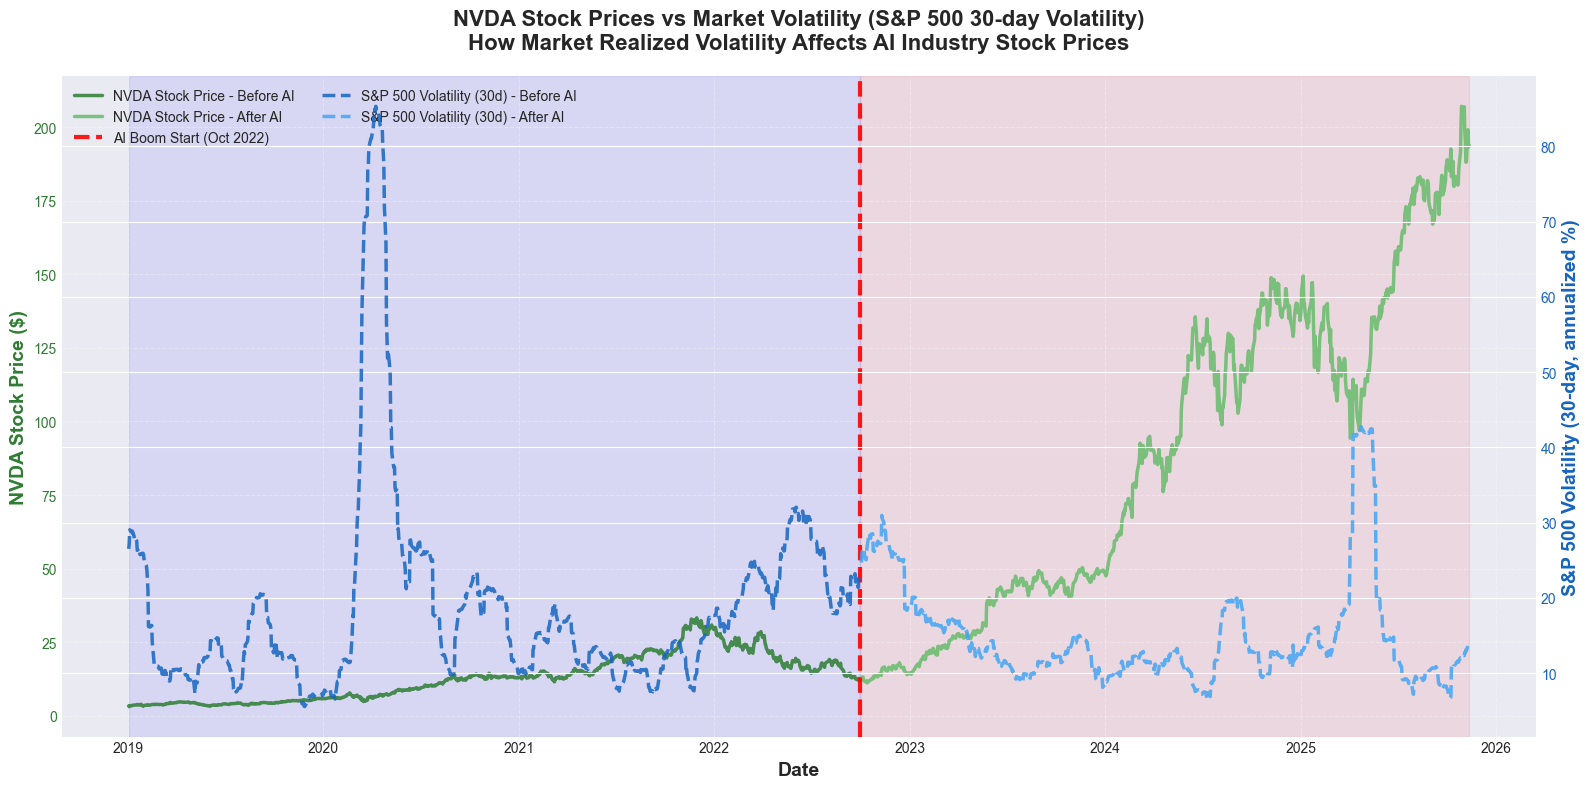

In [4]:
# Plot 1: NVDA Stock Prices vs Market Volatility
fig, ax1 = plt.subplots(figsize=(16, 8))

# Use the data from plot1_data_plot (with datetime index for plotting)
plot1_data_plot_clean = plot1_data_plot.dropna(subset=['SP500_Vol_30d'])

common_dates = plot1_data_plot_clean.index
nvda_prices_aligned = plot1_data_plot_clean['NVDA_Price']
sp500_vol_aligned = plot1_data_plot_clean['SP500_Vol_30d']

# Create period masks
before_mask = common_dates < split_date
after_mask = common_dates >= split_date

# Left y-axis: NVDA Stock Prices (green)
ax1.plot(common_dates[before_mask], nvda_prices_aligned[before_mask], 
        label='NVDA Stock Price - Before AI', color='#2E7D32', linewidth=2.5, alpha=0.85)
ax1.plot(common_dates[after_mask], nvda_prices_aligned[after_mask], 
        label='NVDA Stock Price - After AI', color='#66BB6A', linewidth=2.5, alpha=0.85)
ax1.set_xlabel('Date', fontsize=14, fontweight='bold')
ax1.set_ylabel('NVDA Stock Price ($)', fontsize=14, fontweight='bold', color='#2E7D32')
ax1.tick_params(axis='y', labelcolor='#2E7D32')
ax1.grid(True, alpha=0.3, linestyle='--')

# Right y-axis: S&P 500 30-day Volatility (blue)
ax2 = ax1.twinx()
ax2.plot(common_dates[before_mask], sp500_vol_aligned[before_mask], 
        label='S&P 500 Volatility (30d) - Before AI', color='#1565C0', linewidth=2.5, alpha=0.85, linestyle='--')
ax2.plot(common_dates[after_mask], sp500_vol_aligned[after_mask], 
        label='S&P 500 Volatility (30d) - After AI', color='#42A5F5', linewidth=2.5, alpha=0.85, linestyle='--')
ax2.set_ylabel('S&P 500 Volatility (30-day, annualized %)', fontsize=14, fontweight='bold', color='#1565C0')
ax2.tick_params(axis='y', labelcolor='#1565C0')

# Add vertical line for AI boom start
ax1.axvline(x=split_date, color='red', linestyle='--', linewidth=3, 
          label='AI Boom Start (Oct 2022)', alpha=0.9, zorder=10)

# Add shaded regions for periods
ax1.axvspan(common_dates[0], split_date, 
          alpha=0.08, color='blue', zorder=0)
ax1.axvspan(split_date, common_dates[-1], 
          alpha=0.08, color='red', zorder=0)

# Title
ax1.set_title('NVDA Stock Prices vs Market Volatility (S&P 500 30-day Volatility)\nHow Market Realized Volatility Affects AI Industry Stock Prices', 
            fontsize=16, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10, framealpha=0.95, ncol=2)

plt.tight_layout()
plt.show()


## Plot 2: Volatility Spread Over Time

This plot shows the difference between NVDA and S&P 500 volatility (NVDA_Vol - SP500_Vol) over time. This directly quantifies how much MORE volatile the AI industry is compared to the entire market and highlights when the volatility gap widens or narrows.


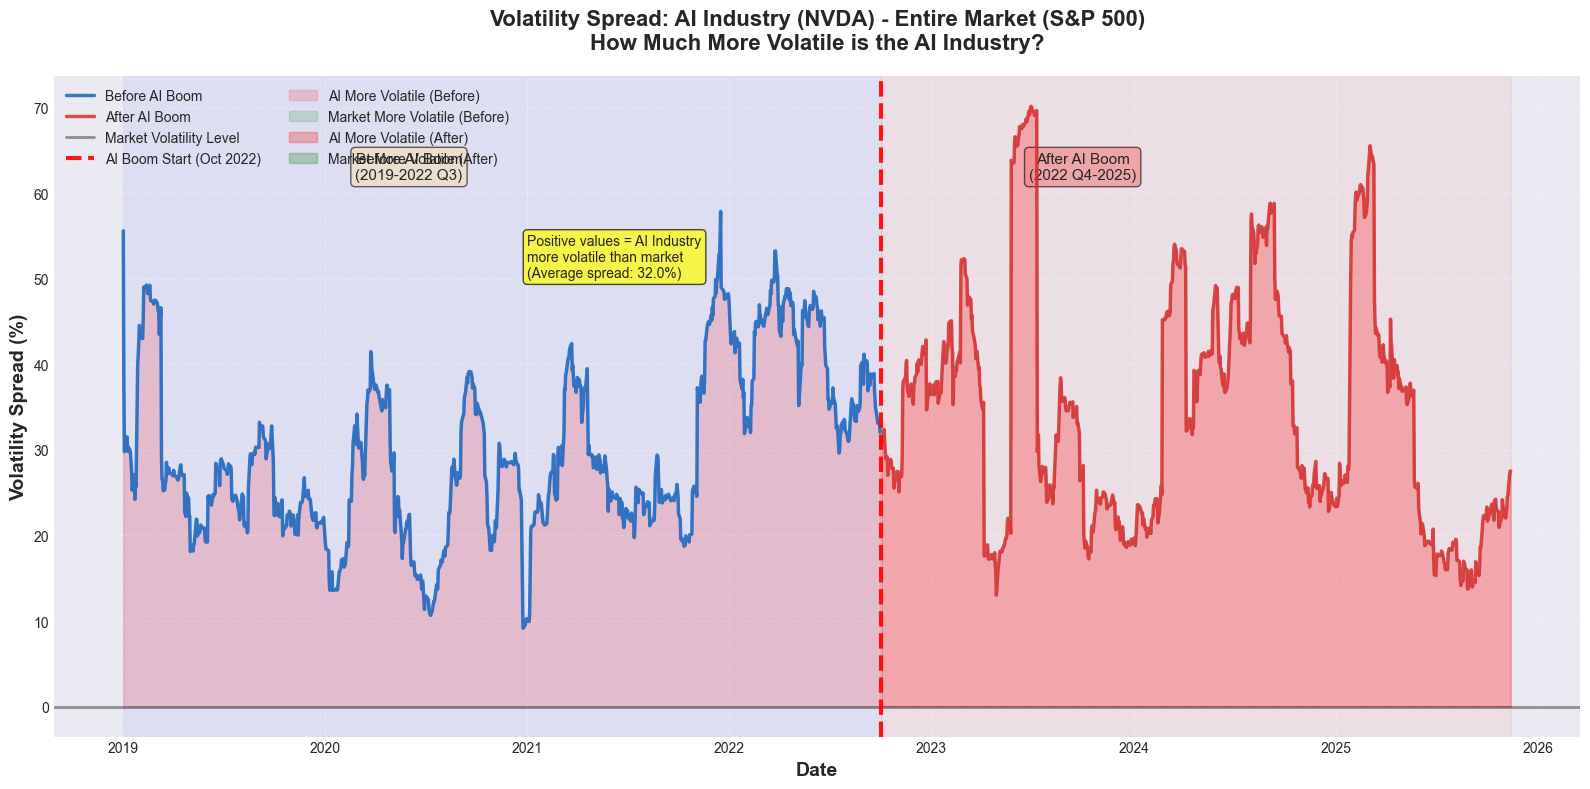

In [5]:
# Plot 2: Volatility Spread Over Time
fig, ax = plt.subplots(figsize=(16, 8))

# Calculate volatility spread using calculated volatilities from yfinance data
plot_data = volatility_data[['NVDA_Vol_30d', 'SP500_Vol_30d']].dropna()
volatility_spread = plot_data['NVDA_Vol_30d'] - plot_data['SP500_Vol_30d']

# Create period masks
before_mask = plot_data.index < split_date
after_mask = plot_data.index >= split_date

# Plot volatility spread with period-based coloring
ax.plot(plot_data.index[before_mask], volatility_spread[before_mask], 
        label='Before AI Boom', color='#1565C0', linewidth=2.5, alpha=0.85, zorder=5)
ax.plot(plot_data.index[after_mask], volatility_spread[after_mask], 
        label='After AI Boom', color='#D32F2F', linewidth=2.5, alpha=0.85, zorder=5)

# Add horizontal line at zero (where AI industry = market volatility)
ax.axhline(y=0, color='black', linestyle='-', linewidth=2, alpha=0.4, 
          label='Market Volatility Level', zorder=3)

# Add vertical line for AI boom start
ax.axvline(x=split_date, color='red', linestyle='--', linewidth=3, 
          label='AI Boom Start (Oct 2022)', alpha=0.9, zorder=10)

# Fill areas above and below zero
ax.fill_between(plot_data.index[before_mask], 0, volatility_spread[before_mask], 
               where=(volatility_spread[before_mask] > 0), alpha=0.15, color='red', 
               label='AI More Volatile (Before)', zorder=1)
ax.fill_between(plot_data.index[before_mask], 0, volatility_spread[before_mask], 
               where=(volatility_spread[before_mask] < 0), alpha=0.15, color='green', 
               label='Market More Volatile (Before)', zorder=1)
ax.fill_between(plot_data.index[after_mask], 0, volatility_spread[after_mask], 
               where=(volatility_spread[after_mask] > 0), alpha=0.25, color='red', 
               label='AI More Volatile (After)', zorder=1)
ax.fill_between(plot_data.index[after_mask], 0, volatility_spread[after_mask], 
               where=(volatility_spread[after_mask] < 0), alpha=0.25, color='green', 
               label='Market More Volatile (After)', zorder=1)

# Add shaded regions for periods
ax.axvspan(plot_data.index[0], split_date, 
          alpha=0.05, color='blue', zorder=0)
ax.axvspan(split_date, plot_data.index[-1], 
          alpha=0.05, color='red', zorder=0)

# Formatting
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Volatility Spread (%)', fontsize=14, fontweight='bold')
ax.set_title('Volatility Spread: AI Industry (NVDA) - Entire Market (S&P 500)\nHow Much More Volatile is the AI Industry?', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10, framealpha=0.95, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--')

# Add text annotations
ax.text(pd.Timestamp('2020-06-01'), ax.get_ylim()[1]*0.88, 'Before AI Boom\n(2019-2022 Q3)', 
       fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6), ha='center', va='top')
ax.text(pd.Timestamp('2023-10-01'), ax.get_ylim()[1]*0.88, 'After AI Boom\n(2022 Q4-2025)', 
       fontsize=11, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.6), ha='center', va='top')

# Add annotation explaining positive values
if volatility_spread.mean() > 0:
    ax.text(pd.Timestamp('2021-01-01'), ax.get_ylim()[1]*0.75, 
           f'Positive values = AI Industry\nmore volatile than market\n(Average spread: {volatility_spread.mean():.1f}%)', 
           fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7), ha='left', va='top')

# Add COVID-19 annotation if visible in the data
covid_date = pd.Timestamp('2020-03-15')
if plot_data.index.min() <= covid_date <= plot_data.index.max():
    covid_spread = volatility_spread.loc[volatility_spread.index.date == covid_date.date()]
    if len(covid_spread) > 0:
        ax.annotate('COVID-19\nVolatility Spike', 
                   xy=(covid_date, volatility_spread.loc[volatility_spread.index.date == covid_date.date()].values[0]),
                   xytext=(pd.Timestamp('2020-05-01'), ax.get_ylim()[1]*0.65),
                   arrowprops=dict(arrowstyle='->', color='darkred', lw=2, alpha=0.7),
                   fontsize=10, bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
                   ha='left')

plt.tight_layout()
plt.show()
